In [1]:
# test the model

import encoding
import argparse
import time
import torch
from torch import nn
import numpy as np
import os
from visualize import center_crop, save_image, save_gif
from encoding import load_encoding
import matplotlib.pyplot as plt
import h5py
from torchvision import transforms
import pandas as pd
import pickle 
from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block
from src.file_utility import save_stuff, flatten_dict, embed_dict

In [2]:
def get_args():
	
	# Init a parser.
	parser = argparse.ArgumentParser (
		prog='NeuroGen', 
		description='Provide an ROI ID to get the optimized images that maxmize its activation.'
	)
	
	# Add arguments to parser.
	parser.add_argument('--roi', type=int, default=0, help='ROI ID, range=[0, 24]') 
	parser.add_argument('--steps', type=int, default=1000, help='number of generations for the optimization.')
	parser.add_argument('--gpu', type=int, default=0, help='GPU ID')
	parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
	parser.add_argument('--subj', type=int, default=1, help='subject ID, rangr [1,8]')
	parser.add_argument('--reptime', type=int, default=1, help='number of repeatations') 
	parser.add_argument('--truncation', type=int, default=1, help='truncation parameter')    
	args = parser.parse_args()

	return args

# my get args
class my_get_args():

    def __init__(self,subject):
        self.subj = subject
        self.steps = 1000
        self.gpu = 0
        self.lr = 0.01
        #self.roi = 1 #FFA

ROI = ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
      

In [3]:
# load images
f = h5py.File('D:/NSD_Dataset/Stimuli/nsd_stimuli.hdf5', 'r+')
stimuli = f['imgBrick']
f.close()

# load shared stimuli id
shared_stimuli_id = pd.read_csv('D:/NSD_Dataset/Stimuli/shared1000.txt', sep='\t', header=None)

shared_stimuli_id

,0
0,2951
1,2991
2,3050
3,3078
4,3147
...,...
995,72313
996,72511
997,72606
998,72720


In [4]:
# predict brain activation

ROI_size = [22, 21, 21, 23, 24, 23, 22, 24]

pred_activation = {'subj01': 0,
                   'subj02': 0,
                   'subj03': 0,
                   'subj04': 0,
                   'subj05': 0,
                   'subj06': 0,
                   'subj07': 0,
                   'subj08': 0,}

# reshape images
# use id-1 for the index of images
shared_image = stimuli[shared_stimuli_id[0]-1,:,:,:].reshape([len(shared_stimuli_id[0]),stimuli.shape[3],stimuli.shape[2],stimuli.shape[2]])
# crop images
shared_image = center_crop(shared_image, shared_image.shape[2], 227)
# normalize
shared_images = (shared_image.astype(np.float32)) / 255

print('input shape', shared_image.shape)

for i in range(1,9): # subjects

    # # creat activation matrix, shape = (1000 images, roi +1 (for image ids))
    # activation = np.zeros([len(shared_stimuli_id), ROI_size[i-1]+1])
    # # store image ids
    # activation[:,-1] = shared_stimuli_id[0]

    #create args for subject i
    args = my_get_args(i)
    # choose device
    device = torch.device("cuda:%d"%args.gpu if torch.cuda.is_available() else "cpu")
    # load encoding models
    fwrf, fmaps = load_encoding(args.subj, model_name='dnn_fwrf', device=device)
    print('subj', args.subj)
    # load params
    model_params_set = h5py.File(f'C:/Users/mjahani/NSD_fMRI/NeuroGen/output/S{i:02d}/dnn_fwrf/model_params.h5py', 'r')
    model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
    model_params_set.close()
    
    # predict
    pred = get_predictions(shared_image, fmaps, fwrf, model_params['params'])

    # add stimulus id
    pred = np.append(pred, shared_stimuli_id[0].values.reshape(-1,1), axis=1)
    #print(pred.shape)

    # store in dictionary
    pred_activation[f'subj{i:02d}'] = pred


with open('predicted_activation/pred_act', 'wb') as f:
  pickle.dump(pred_activation, f)

pred_activation




input shape (1000, 3, 227, 227)
subj 1
samples [  900:999  ] of 1000, voxels [     0:21    ] of 22
---------------------------------------
total time = 3.443613s
sample throughput = 0.003444s/sample
voxel throughput = 0.156528s/voxel
subj 2
samples [  900:999  ] of 1000, voxels [     0:20    ] of 21
---------------------------------------
total time = 3.402605s
sample throughput = 0.003403s/sample
voxel throughput = 0.162029s/voxel
subj 3
samples [  900:999  ] of 1000, voxels [     0:20    ] of 21
---------------------------------------
total time = 3.367099s
sample throughput = 0.003367s/sample
voxel throughput = 0.160338s/voxel
subj 4
samples [  900:999  ] of 1000, voxels [     0:22    ] of 23
---------------------------------------
total time = 3.403105s
sample throughput = 0.003403s/sample
voxel throughput = 0.147961s/voxel
subj 5
samples [  900:999  ] of 1000, voxels [     0:23    ] of 24
---------------------------------------
total time = 3.406106s
sample throughput = 0.003406s/

{'subj01': array([[   16,   252,    53, ...,    20,    50,  2951],
        [   17,   245,    25, ...,     1,    37,  2991],
        [  247,   236,     2, ...,   236,    23,  3050],
        ...,
        [  251,   245,     7, ...,   245,    14, 72606],
        [  246,   236,    22, ...,   235,    22, 72720],
        [    5,   245,    34, ...,   255,    29, 72949]], dtype=int64),
 'subj02': array([[   34,   239,   189, ...,   244,    33,  2951],
        [    6,   213,   184, ...,   230,   239,  2991],
        [   28,   227,   226, ...,   243,     5,  3050],
        ...,
        [   15,   224,   196, ...,   239,   220, 72606],
        [   33,   241,   225, ...,   242,     5, 72720],
        [   38,   241,   204, ...,   239,    22, 72949]], dtype=int64),
 'subj03': array([[   24,     1,   245, ...,    86,    78,  2951],
        [    6,   252,   237, ...,    54,    46,  2991],
        [  249,   251,   236, ...,    34,    30,  3050],
        ...,
        [    2,   251,     0, ...,    22,    3

In [18]:
# ROI_size = [22, 21, 21, 23, 24, 23, 22, 24]

# pred_activation = {'subj01': 0,
#                    'subj02': 0,
#                    'subj03': 0,
#                    'subj04': 0,
#                    'subj05': 0,
#                    'subj06': 0,
#                    'subj07': 0,
#                    'subj08': 0,}
# k = 0
# for i in range(1,9): # subjects

#     # creat activation matrix, shape = (1000 images, roi +1 (for image ids))
#     activation = np.zeros([len(shared_stimuli_id), ROI_size[i-1]+1])
#     # store image ids
#     activation[:,-1] = shared_stimuli_id[0]

#     # create args for subject i
#     args = my_get_args(i)
#     # choose device
#     device = torch.device("cuda:%d"%args.gpu if torch.cuda.is_available() else "cpu")
#     # load encoding model fwrf and fmaps
#     fwrf, fmaps = load_encoding(subject=args.subj, model_name='dnn_fwrf', device=device)
    
#     for j in range(len(shared_stimuli_id)): # images

#         # choose 1 image
#         y = stimuli[shared_stimuli_id[0][j],:,:,:]
#         #print('initial shape', y.shape, type(y))
#         # reshape to (1,3,n,n)
#         y = y.reshape([1,y.shape[2],y.shape[1],y.shape[1]])
#         #crop
#         y = center_crop(y, y.shape[2], 227)
#         # pytorch tensor
#         y = torch.from_numpy(y).float().to(device)
#         #print('final shape', y.shape, type(y))

#         # predict brain response
#         pred = fwrf(fmaps(y))
        
#         activation[j,:-1] = pred.detach().numpy()
    
#     pred_activation[f'subj{i:02d}'] = activation
    


# with open('predicted_activation/pred_act', 'wb') as f:
#     pickle.dump(pred_activation, f)

#pred_activation.to_csv('predicted_activation/pred_act.csv', sep='\t', index=False)



In [6]:
# try the output       
with open('predicted_activation/pred_act', 'rb') as f:
    pred_activation = pickle.load(f)

pred_activation

{'subj01': array([[   16,   252,    53, ...,    20,    50,  2951],
        [   17,   245,    25, ...,     1,    37,  2991],
        [  247,   236,     2, ...,   236,    23,  3050],
        ...,
        [  251,   245,     7, ...,   245,    14, 72606],
        [  246,   236,    22, ...,   235,    22, 72720],
        [    5,   245,    34, ...,   255,    29, 72949]], dtype=int64),
 'subj02': array([[   34,   239,   189, ...,   244,    33,  2951],
        [    6,   213,   184, ...,   230,   239,  2991],
        [   28,   227,   226, ...,   243,     5,  3050],
        ...,
        [   15,   224,   196, ...,   239,   220, 72606],
        [   33,   241,   225, ...,   242,     5, 72720],
        [   38,   241,   204, ...,   239,    22, 72949]], dtype=int64),
 'subj03': array([[   24,     1,   245, ...,    86,    78,  2951],
        [    6,   252,   237, ...,    54,    46,  2991],
        [  249,   251,   236, ...,    34,    30,  3050],
        ...,
        [    2,   251,     0, ...,    22,    3

shape (1000,)


,image id,avg act
0,2951,149.500
1,2991,170.500
2,3050,177.375
3,3078,213.000
4,3147,230.250
...,...,...
995,72313,213.750
996,72511,198.125
997,72606,207.250
998,72720,148.125


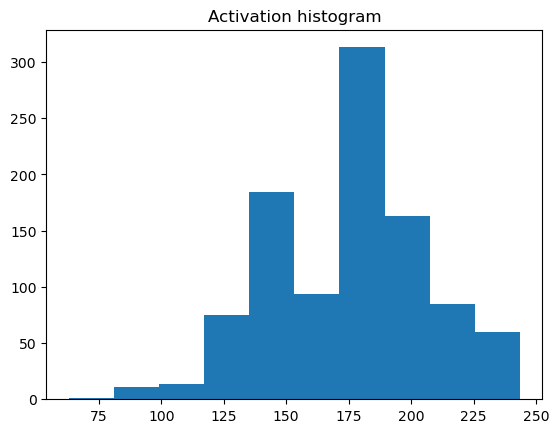

In [12]:
# exploring results
act_FFA = pred_activation['subj01'][:,1]

for i in range(2,9):
    act_FFA = act_FFA + pred_activation[f'subj{i:02d}'][:,1]

# avergae over participnats
act_FFA = act_FFA/8

print('shape', act_FFA.shape)
plt.hist(act_FFA)
plt.title('Activation histogram')

pred_act = pd.DataFrame({
    'image id': shared_stimuli_id[0],
    'avg act':act_FFA,
})

pred_act

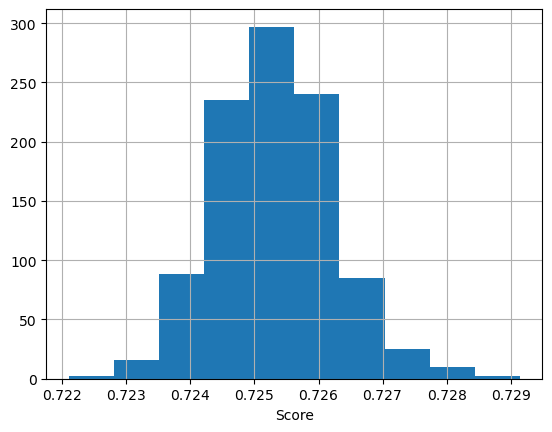

In [13]:
pred_score = pd.DataFrame({
    'image id': shared_stimuli_id[0],
    'score':pd.read_csv('C:/Users/mjahani/NSD_behavior/memorability_scores.csv', sep=',', header=None).squeeze(),
})

pred_score['score'].hist()
plt.xlabel('Score')
mean_score = pred_score['score'].mean()
median_score = pred_score['score'].median()


In [14]:
#separate memorable and non-memorable images

high_mem_act = pred_act['avg act'][pred_act['image id'].isin(pred_score['image id'][pred_score['score']> median_score])]
low_mem_act = pred_act['avg act'][pred_act['image id'].isin(pred_score['image id'][pred_score['score']<= median_score])]

print('higher than median:', high_mem_act.shape[0])
print('lower than median:', low_mem_act.shape[0])

higher than median: 500
lower than median: 500


Text(0.5, 0, 'activation')

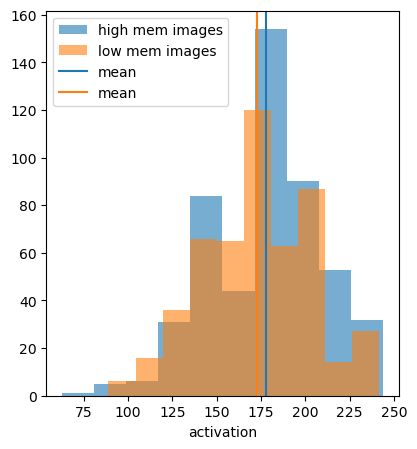

In [15]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.hist(high_mem_act, alpha=0.6, label='high mem images')
plt.hist(low_mem_act, alpha=0.6, label='low mem images')
plt.axvline(high_mem_act.mean(), color='#1f77b4', label='mean')
plt.axvline(low_mem_act.mean(), color='#ff7f0e', label='mean')
plt.legend()
plt.xlabel('activation')


In [17]:
# subj = 1
# pred1 = pred_activation[f'subj{subj:02d}'][:,15]
# print(pred1.shape)
# mean_beta = pd.read_csv(f'C:/Users/mjahani/NSD_fMRI/NeuroGen/roiavgbeta/subj{subj:02d}/meanbeta_V1v.txt', sep='\t', header=None)
# print(mean_beta.shape)
# mean_beta.hist()

In [111]:
from scipy import stats

#t_stat, p_val = stats.ttest_ind(high_mem_act.reset_index(drop=True), low_mem_act.reset_index(drop=True)) 
#print(t_stat, p_val)

